<a href="https://colab.research.google.com/github/aitorvv96/road_to_AI/blob/main/Tensorflow/Ringa_Tech/Transfer_Learning/Transfer_Learning_en_la_cocina.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Fuente:**

https://www.youtube.com/watch?v=9Dur_oUMGG8&list=PLZ8REt5zt2Pn0vfJjTAPaDVSACDvnuGiG&index=7&t=12s&ab_channel=RingaTech

Los principales problemas de usar IA es conseguir datos de entrenamiento y el tiempo y coste del entrenamiento. La **transferencia de aprendizaje** nos permite combatir este problema.  
Lo que hace esta técnica es utilizar un modelo previamente entrenado en un caso de estudio con cierta similitud, haciendo uso de su aprendizaje previo y adaptándolo a nuestro caso de estudio.

En este ejemplo escogeremos una red neuronal MobileNet V2, eliminaremos su capa de salida (1,001 neuronas) y agregamos nuestra capa de salida (3 neuronas, ya que queremos distinguir imágenes entre cuchillo, tenedor y cuchara). Para evitar que se vuelva a entrenar la parte del código que estamos reutilizando en nuestro caso de estudio, lo que haremos será congelarla y entrenar únicamente el apartado nuevo (capa de salida).  
Otras técnicas serían añadir nuevas capas antes de la capa de salida, o reentrenar algunas de las capas del modelo reutilizado. Otra opción es entrenar nuestra capa de salida, y una vez entrenada reentrenar el resto del modelo (el reutilizado) por unas pocas iteraciones, con tasas de aprendizaje bajas. 

**Paso 1:**  
Descargar un set de imágenes y comprimirlo en .zip, clasificando las imágenes en tenedores, cuchillos y cucharas. Para ello podemos utilizar [Download AII Images ](https://chrome.google.com/webstore/detail/download-all-images/ifipmflagepipjokmbdecpmjbibjnakm). Posteriormente, subirlo a las carpetas que se crean a continuación.  
Los pasos posteriores organizan la información y amplifican el set de datos utilizado.

In [1]:
#Crear las carpetas para subir las imagenes
!mkdir cuchillos
!mkdir cucharas
!mkdir tenedores

In [ ]:
#Entrar en cada carpeta y descomprimir el archivo zip
%cd cuchillos
!unzip cuchillos.zip
%cd ..

%cd tenedores
!unzip tenedores.zip
%cd ..

%cd cucharas
!unzip cucharas.zip
%cd ..

In [3]:
#Borrar los archivo ZIP
!rm -rf /content/cucharas/cucharas.zip
!rm -rf /content/cuchillos/cuchillos.zip
!rm -rf /content/tenedores/tenedores.zip

In [4]:
#Mostrar cuantas imagenes tengo de cada categoria
!ls /content/cucharas | wc -l #475
!ls /content/cuchillos | wc -l #515
!ls /content/tenedores | wc -l #419

6
6
6


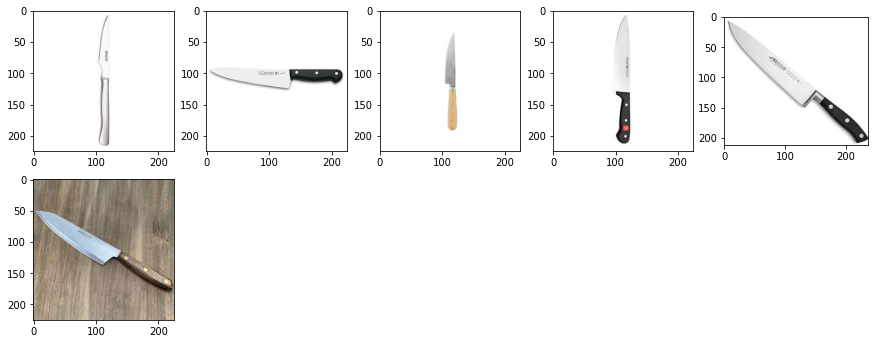

In [5]:
#Mostrar algunas imagenes con pyplot
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

plt.figure(figsize=(15,15))

carpeta = '/content/cuchillos'
imagenes = os.listdir(carpeta)

for i, nombreimg in enumerate(imagenes[:25]):
  plt.subplot(5,5,i+1)
  imagen = mpimg.imread(carpeta + '/' + nombreimg)
  plt.imshow(imagen)

In [6]:
#Crear carpetas para hacer el set de datos

!mkdir dataset
!mkdir dataset/cuchillo
!mkdir dataset/tenedor
!mkdir dataset/cuchara

In [7]:
#Copiar imagenes que subimos a carpetas del dataset
#Limitar para que todos tengan la misma cantidad de imagenes
#maximo 419 (el num. menor de imagenes que subi)

import shutil
carpeta_fuente = '/content/cuchillos'
carpeta_destino = '/content/dataset/cuchillo'

imagenes = os.listdir(carpeta_fuente)

for i, nombreimg in enumerate(imagenes):
  if i < 419:
    #Copia de la carpeta fuente a la destino
    shutil.copy(carpeta_fuente + '/' + nombreimg, carpeta_destino + '/' + nombreimg)

In [8]:
carpeta_fuente = '/content/tenedores'
carpeta_destino = '/content/dataset/tenedor'

imagenes = os.listdir(carpeta_fuente)

for i, nombreimg in enumerate(imagenes):
  if i < 419:
    #Copia de la carpeta fuente a la destino
    shutil.copy(carpeta_fuente + '/' + nombreimg, carpeta_destino + '/' + nombreimg)

In [9]:
carpeta_fuente = '/content/cucharas'
carpeta_destino = '/content/dataset/cuchara'

imagenes = os.listdir(carpeta_fuente)

for i, nombreimg in enumerate(imagenes):
  if i < 419:
    #Copia de la carpeta fuente a la destino
    shutil.copy(carpeta_fuente + '/' + nombreimg, carpeta_destino + '/' + nombreimg)

In [ ]:
#Mostrar cuantas imagenes tengo de cada categoria en el dataset
!ls /content/dataset/cuchara | wc -l
!ls /content/dataset/cuchillo | wc -l
!ls /content/dataset/tenedor | wc -l

Found 15 images belonging to 3 classes.
Found 3 images belonging to 3 classes.


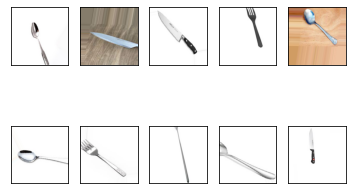

In [11]:
#Aumento de datos con ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

#Crear el dataset generador
datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range = 30,
    width_shift_range = 0.25,
    height_shift_range = 0.25,
    shear_range = 15,
    zoom_range = [0.5, 1.5],
    validation_split=0.2 #20% para pruebas
)

#Generadores para sets de entrenamiento y pruebas
data_gen_entrenamiento = datagen.flow_from_directory('/content/dataset', target_size=(224,224),
                                                     batch_size=32, shuffle=True, subset='training')
data_gen_pruebas = datagen.flow_from_directory('/content/dataset', target_size=(224,224),
                                                     batch_size=32, shuffle=True, subset='validation')

#Imprimir 10 imagenes del generador de entrenamiento
for imagen, etiqueta in data_gen_entrenamiento:
  for i in range(10):
    plt.subplot(2,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(imagen[i])
  break
plt.show()


**Paso 2:**  
Buscamos y descargamos el modelo preentrenado que queremos utilizar.  
Construimos nuestro modelo con el anterior como referencia y lo entrenamos. Vemos gráficamente el resultado del modelo entrenado.

In [12]:
import tensorflow as tf
import tensorflow_hub as hub

url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
mobilenetv2 = hub.KerasLayer(url, input_shape=(224,224,3))

In [13]:
#Congelar el modelo descargado
mobilenetv2.trainable = False

In [15]:
# Crear un modelo nuevo de tipo secuencial reutilizando el modelo original
# y añadiendo la capa de salida deseada
modelo = tf.keras.Sequential([
    mobilenetv2,
    tf.keras.layers.Dense(3, activation='softmax')
])

In [16]:
modelo.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense_1 (Dense)             (None, 3)                 3843      
                                                                 
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params: 2,257,984
_________________________________________________________________


In [17]:
#Compilar como siempre
modelo.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
#Entrenar el modelo
EPOCAS = 50

historial = modelo.fit(
    data_gen_entrenamiento, epochs=EPOCAS, batch_size=32,
    validation_data=data_gen_pruebas
)

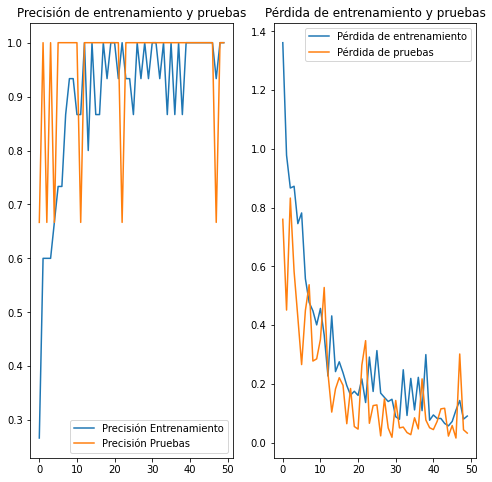

In [19]:
#Graficas de precisión
acc = historial.history['accuracy']
val_acc = historial.history['val_accuracy']

loss = historial.history['loss']
val_loss = historial.history['val_loss']

rango_epocas = range(50)

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(rango_epocas, acc, label='Precisión Entrenamiento')
plt.plot(rango_epocas, val_acc, label='Precisión Pruebas')
plt.legend(loc='lower right')
plt.title('Precisión de entrenamiento y pruebas')

plt.subplot(1,2,2)
plt.plot(rango_epocas, loss, label='Pérdida de entrenamiento')
plt.plot(rango_epocas, val_loss, label='Pérdida de pruebas')
plt.legend(loc='upper right')
plt.title('Pérdida de entrenamiento y pruebas')
plt.show()

**Paso 3:**  
Probamos el modelo diseñado con imágenes de internet y lo exportamos.

In [20]:
#Categorizar una imagen de internet
from PIL import Image
import requests
from io import BytesIO
import cv2

def categorizar(url):
  respuesta = requests.get(url)
  img = Image.open(BytesIO(respuesta.content))
  img = np.array(img).astype(float)/255

  img = cv2.resize(img, (224,224))
  prediccion = modelo.predict(img.reshape(-1, 224, 224, 3))
  return np.argmax(prediccion[0], axis=-1)


En este apartado podemos sustituir la url por la deseada para probar el modelo.

In [ ]:
#0 = cuchara, 1 = cuchillo, 2 = tenedor
url = 'https://th.bing.com/th/id/R.e44940120b7b67680af246c3b3e936f2?rik=XZPLfxf4nHlzyw&pid=ImgRaw&r=0' #debe ser 2
prediccion = categorizar (url)
print(prediccion)

In [22]:
#Crear la carpeta para exportarla a TF Serving
!mkdir -p carpeta_salida/modelo_cocina/1

In [23]:
#Guardar el modelo en formato SavedModel
modelo.save('carpeta_salida/modelo_cocina/1')

INFO:tensorflow:Assets written to: carpeta_salida/modelo_cocina/1/assets


INFO:tensorflow:Assets written to: carpeta_salida/modelo_cocina/1/assets


In [24]:
#Hacerlo un zip para bajarlo y usarlo en otro lado
!zip -r modelo_cocina.zip /content/carpeta_salida/modelo_cocina/

  adding: content/carpeta_salida/modelo_cocina/ (stored 0%)
  adding: content/carpeta_salida/modelo_cocina/1/ (stored 0%)
  adding: content/carpeta_salida/modelo_cocina/1/saved_model.pb (deflated 92%)
  adding: content/carpeta_salida/modelo_cocina/1/variables/ (stored 0%)
  adding: content/carpeta_salida/modelo_cocina/1/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: content/carpeta_salida/modelo_cocina/1/variables/variables.index (deflated 78%)
  adding: content/carpeta_salida/modelo_cocina/1/keras_metadata.pb (deflated 80%)
  adding: content/carpeta_salida/modelo_cocina/1/assets/ (stored 0%)
